# In this notebook, I am going to implement a deep network from numpy



In [1]:
# Python Standard Library struct and array
# for dealing with reading dataset from file
import struct
from array import array
from time import time

# Numpy for calculating
import numpy as np

# To draw the training and dev cost value curve
import matplotlib.pyplot as plt
%matplotlib inline

# Test Cases
import test

# Some Useful Helper Functions
import helper

# Part 1. Preparing Data

## Load MNIST Dataset

In [2]:
def load_mnist():
    """ 
    load MNIST dataset into numpy array 
    MNIST dataset can be downloaded manually.
    url: http://yann.lecun.com/exdb/mnist/
    """
    ret = {}
    with open('MNIST/train-images.idx3-ubyte', 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        assert(magic==2051)
        ret['X_train'] = np.array(array("B", f.read())).reshape(size,rows,cols)

    with open('MNIST/t10k-images.idx3-ubyte', 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        assert(magic==2051)
        ret['X_test'] = np.array(array("B", f.read())).reshape(size,rows,cols)

    with open('MNIST/train-labels.idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        assert(magic==2049)
        ret['Y_train'] = np.array(array("B", f.read())).reshape(size,1)

    with open('MNIST/t10k-labels.idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        assert(magic==2049)
        ret['Y_test'] = np.array(array("B", f.read())).reshape(size,1)

    return ret

## Shuffle and divide the dataset

In [3]:
def shuffle_divide_dataset( dataset, len_of_dev=10000 ):
    """
    Shuffle and divide the dataset
    
    len_of_dev: 10,000 is a reasonable number for dev set.
                Dev dataset with this size is big enough to measure variance problem.
    """       
    assert('X_train' in dataset)
    assert(len(dataset)==4)
    
    """ random shuffle the training set """
    np.random.seed(1)
    permutation = np.random.permutation(dataset['X_train'].shape[0])
    dataset['X_train'] = dataset['X_train'][permutation]
    dataset['Y_train'] = dataset['Y_train'][permutation]

    """ divide trainset into trainset and devset """
    dataset['X_dev'] = dataset['X_train'][:len_of_dev]
    dataset['Y_dev'] = dataset['Y_train'][:len_of_dev]
    dataset['X_train'] = dataset['X_train'][len_of_dev:]
    dataset['Y_train'] = dataset['Y_train'][len_of_dev:]

    return dataset

## Manually check the dataset by random visualize some of them

In [4]:
def manually_validate_mnist_dataset(dataset):
    """Manually check the dataset by random visualize some of them"""
    random_train = np.random.randint(1, len(dataset['X_train']))-1
    random_dev = np.random.randint(1, len(dataset['X_dev']))-1
    random_test = np.random.randint(1, len(dataset['X_test']))-1
    print(dataset['Y_train'][random_train], dataset['Y_dev'][random_dev], dataset['Y_test'][random_test])
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=[10,3])
    ax1.imshow(dataset['X_train'][random_train], cmap='gray')
    ax2.imshow(dataset['X_dev'][random_dev], cmap='gray')
    mappable = ax3.imshow(dataset['X_test'][random_test], cmap='gray')
    fig.colorbar(mappable)
    plt.show()

## Standardize the dataset

$$
z = \frac{x - \mu}{\sigma}
$$

#### Notice: the MNIST gray images have a lot of areas of black (0), relatively few areas of white(255), so the standardization has a result of roughly (-0.4, 2.8).
#### Maybe we can also use divide 256 to scale the dataset.

In [5]:
def standardize( dataset ):
    """use standard sccore to normalize input dataset"""
    assert('X_train' in dataset)
    mu = np.mean(dataset['X_train'], keepdims=False)
    sigma = np.std(dataset['X_train'], keepdims=False)
    for key, val in dataset.items():
        if key[:2]=='X_':
            dataset[key] = ( dataset[key] - mu ) / sigma
    return dataset

## Preprocess dataset into vectors
#### Notice: Andrew's course use the format of vector above, but tensorflow does it in it's transpose way.
## Flat Images(X) into vectors, and stack them into matrix

#### Input Format: X (m, width, height); Output Format:
$$ X = 
\begin{bmatrix}
\vert & & \vert & & \vert \\
x^{(1)} & ... & x^{(i)} & ... & x^{(m)} \\
\vert & & \vert & & \vert
\end{bmatrix} 
$$

In [6]:
def flat_stack( dataset ):
    """input dataset format: (m, width, height)"""
    for key, val in dataset.items():
        if key[:2]=='X_':
            width = dataset[key].shape[1]
            height = dataset[key].shape[2]
            dataset[key] = dataset[key].reshape(-1, width*height).T
    return dataset

## One hot encode Labels(Y)
#### Input Format: Y (m, label_number); output Format:
$$
Y = 
\begin{bmatrix}
\vert & & \vert & & \vert \\
y_{one\_hot}^{(1)} & ... & y_{one\_hot}^{(i)} & ... & y_{one\_hot}^{(m)} \\
\vert & & \vert & & \vert \\
\end{bmatrix}
$$


In [7]:
def one_hot( dataset ):
    min_label_number = np.min(dataset['Y_train'], keepdims=False)
    max_label_number = np.max(dataset['Y_train'], keepdims=False)
    C = max_label_number - min_label_number + 1
    for key, val in dataset.items():
        if key[:2]=='Y_':
            # all label number should be trained in Y_train
            assert(min_label_number <= np.min(dataset[key], keepdims=False))
            assert(max_label_number >= np.max(dataset[key], keepdims=False))
            Y = dataset[key]
            Y_onehot = np.zeros((C, Y.shape[0]))
            Y_onehot[Y.reshape(-1).astype(int), np.arange(Y.shape[0])] = 1
            dataset[key] = Y_onehot
    return dataset

def back_one_hot(Y_onehot):
    """ This is an inverse function of one hot, in case we need to interpret the result. """
    Y = np.repeat( [np.arange(Y_onehot.shape[0])], repeats=Y_onehot.shape[1], axis=0 )
    assert(Y.shape == Y_onehot.T.shape)
    Y = Y[Y_onehot.T.astype(bool)]
    return Y.reshape(-1,1)

## Init cache, parameters, hyper_parameters

**cache** is used for store results in steps, such as Z1, A1, Z2, A2 and so on.

**parameters** are the model itself, consist of W and b, which can be adjusted during training.

**hyper_parameters** are the settings for training.

_(I am still thinking should the structure of the network be a parameter? Or should there be structure, parameters, training conditions?)_

In [8]:
def init(X_size, hidden_layers=[10,10,5], C=10, learning_rate=0.01, 
         regularization=0.1, keep_parameters=True, keep_prop=1):
    """ init cache, parameters and hyper_parameters """
    global cache, parameters, hyper_parameters

    #if the layers changed, there is no way to keep parameters.
    if 'hyper_parameters' in globals():
        if hyper_parameters['layers']!=hidden_layers+[C]:
            print(hyper_parameters['layers'],hidden_layers+[C])
            keep_parameters=False
            
    cache = {}
    hyper_parameters = {}

    """ init hyper_parameters """
    hyper_parameters['X_size'] = X_size
    # layers of network, include the last softmax layer
    # hidden layers use ReLU activation function, and the last layer use Softmax function
    hyper_parameters['layers'] = hidden_layers + [C]
    # L layers in total
    hyper_parameters['L'] = len(hyper_parameters['layers'])
    # Class numbers 0-9 is 10
    hyper_parameters['C'] = C
    hyper_parameters['learning_rate'] = learning_rate
    hyper_parameters['regularization'] = regularization
    hyper_parameters['keep_prop'] = keep_prop
    
    """ init W b or any other parameters in every layer """
    layers = hyper_parameters['layers']
    x_size = hyper_parameters['X_size']
    if not keep_parameters or 'parameters' not in globals():
        parameters = {}
        print("re-init parameters.")
        cells_prev = x_size
        for layer_idx, cells in enumerate(layers):
            parameters['W'+str(layer_idx+1)] = np.random.randn(cells, cells_prev) * 0.01
            parameters['b'+str(layer_idx+1)] = np.zeros((cells, 1))
            cells_prev = layers[layer_idx]

# Part 2. Neural Network calculations

## Core calculation functions and their backpropagations
_(I cannot split the backpropagation into seperated independent steps, since I cannot understand Matrix-by-Matrix derivatives.)_

_(For example, the linear matrix function: $Y=WX+B$. What is $\frac{\partial Y}{\partial X}$? I assume that will be a four-rank tensor, but I cannot understand that.)_


$$
ReLu = max(0, x)
$$
***
$$
\frac{\partial Loss}{\partial Z} = 
\frac{\partial Loss}{\partial A} \cdot \frac{\partial A}{\partial Z} =
\frac{\partial Loss}{\partial A} \cdot (Z >= 0)
$$

In [9]:
def relu(Z):
    A = Z * ( Z>=0 )
    return A
def relu_backpropagation(Z, A, dL_dA):
    """ No need for A """
    dL_dZ = np.multiply(dL_dA, (Z>=0).astype(np.float32))
    return dL_dZ

$$
Softmax = \frac{\exp(Z)}{\sum_i^n{\exp(Z)}}
$$

***
I am not sure about the formula of derivative of Softmax with m examples batched. If m=1, I have this formula:

$$
\frac{\partial Loss}{\partial Z} = 
\frac{\partial Loss}{\partial A} \cdot \frac{\partial A}{\partial Z} =
\frac{\partial Loss}{\partial A} \cdot A * (I-A^{\intercal})
$$

***
It's lucky that I noticed tensorflow combines softmax and loss functions together into one softmax_and_cross_entropy function, so I just use that way to calculate, skipping calculating dL_dA:

$$
\frac{\partial Loss}{\partial Z} = 
\hat{Y} - Y
$$

But there are some strange notation after that, I don't know why it should look like this, I added them to pass the gradient check:
$$
\frac{n}{(n-1)m}
$$

In [10]:
def softmax(Z):
    Z = Z - np.max(Z, axis=0) # This line is avoid exp overflow, since [1,2] and [1001,1002] have the same softmax result.
    exp_Z = np.exp(Z)
    A = exp_Z / np.sum(exp_Z, axis=0)
    return A
def softmax_loss_backpropagation(A, Y):
    """
    Directly calculate dL_dZ from A and Y, combining softmax and loss functions.
    It's quite difficult to calculate them seperately.
    In fact, I can't calculate derivative of softmax with mini-batches.
    """
    m = A.shape[1]
    n = A.shape[0]
    dL_dZ = (A - Y) * n / (n-1) / m
    return dL_dZ

$$
Z = W A_{prev} + B
$$
***
$$
\frac{\partial Loss}{\partial A_{prev}} = 
\frac{\partial Loss}{\partial Z} \cdot \frac{\partial Z}{\partial A_{prev}} =
\frac{\partial Loss}{\partial Z} \cdot A_{prev}^{\intercal}
$$

$$
\frac{\partial Loss}{\partial W} = 
\frac{\partial Loss}{\partial Z} \cdot \frac{\partial Z}{\partial W} =
W^\intercal \cdot \frac{\partial Loss}{\partial Z}
$$

$$
\frac{\partial Loss}{\partial B} = 
\frac{\partial Loss}{\partial Z} \cdot \frac{\partial Z}{\partial B} =
\frac{\partial Loss}{\partial Z} \cdot 1
$$

In [11]:
def linear(A_prev, W, B):
    Z = np.dot(W, A_prev) + B
    return Z
def linear_backpropagation(A_prev, W, B, dL_dZ):
    """ No need for B """
    m = dL_dZ.shape[1]
    dL_dA_prev = np.dot(W.T, dL_dZ)
    dL_dW = 1 * np.dot(dL_dZ, A_prev.T)
    dL_db = 1 * np.sum(dL_dZ, axis=1).reshape(-1,1)
    return dL_dA_prev, dL_dW, dL_db

$$
Loss = -\frac{1}{m} \sum_i^m \sum_j^C {(y_j^{(i)}\log(\hat{y}_j^{(i)}) + (1-y_j^{(i)})\log(1-\hat{y}_j^{(i)}))}
$$
#### Notice: if I omit the 1e-10 thing, the A should reach 0.0 or 1.0, therefore the result of log or divide will give a runtime error.

In [12]:
TINY = 1e-10
def loss(A, Y):
    """ where A is Y_hat, loss is L in every dL """
    cost = np.multiply(Y, np.log(A+TINY)) + np.multiply(1-Y, np.log(1 - A+TINY))
    loss = -np.mean(np.sum(cost, axis=0), keepdims=False)
    return loss
def loss_backpropagation(A, Y):
    m = A.shape[1]
    dL_dA = - (np.divide(Y, A+TINY) - np.divide(1 - Y, 1 - A+TINY)) / m
    return dL_dA

$$
accuracy = \frac{\sum_i^m (y^{[i]}==\hat{y}^{[i]})}{m}
$$

In [13]:
def predict(Y_hat):
    return np.argmax(Y_hat, axis=0).reshape(-1,1)

def accuracy(Y_predict, Y):
    return np.sum(np.equal(Y_predict, back_one_hot(Y))) / Y_predict.shape[0]

# Part 3. Optimization

### L2 Regularization
$$
Loss_{reg} = Loss + \frac{\lambda}{2}(\sum_l^L W^{[l] \intercal} \cdot W^{[l]})
$$

$$
\Delta \frac{\partial L}{\partial W^{[l]}} = \frac{\lambda}{m}W^{[l]}
$$

In [14]:
def loss_with_regularization(loss):
    global parameters, hyper_parameters
    if hyper_parameters['regularization']==0:
        return loss
    s = 0
    for i in range(hyper_parameters['L']):
        L = str(i+1)
        s += np.sum(np.mean(np.dot(parameters['W'+L].T, parameters['W'+L]), axis=1), keepdims=False)
    
    loss += hyper_parameters['regularization'] / 2 * s
    return loss

def dL_dW_incremental_with_regularization(L):
    global cache, parameters, hyper_parameters
    if hyper_parameters['regularization']==0:
        return 0
    m = cache['Z1'].shape[1]
    return hyper_parameters['regularization'] * parameters['W'+L] / m

### Dropout

In [15]:
def dropout(A, layer):
    global cache
    if layer>0 and layer<hyper_parameters['L'] and hyper_parameters['keep_prop']<1:
        cache['dropout'+str(layer)] = np.random.rand(A.shape[0], A.shape[1]) < hyper_parameters['keep_prop']
        A = A * cache['dropout'+str(layer)] / hyper_parameters['keep_prop']
    return A
def dropout_backpropagation(A, layer, dA):
    """ No need for A """
    global cache
    if layer>0 and layer<hyper_parameters['L'] and hyper_parameters['keep_prop']<1:
        dA = dA * cache['dropout'+str(layer)]
    return dA

# Part 4. Neural network logic

```
Init all parameters ---> forward propagation ---+---> compute loss
                     ^            +             |
                     |            |             +---> compute accuracy
                     |            v
                     |     back propagation
                     |            +
                     |            |
                     |            v
                     |     update parameters
                     |            +
                     |            |
                     +------------+
```

In [16]:
""" neural network logic level """

def forwardpropagation_all(X, Y, with_dropout=True):
    global cache, parameters, hyper_parameters
    layers = hyper_parameters['layers']
    A_prev = X
    for layer_idx, cells in enumerate(layers):
        W = parameters['W'+str(layer_idx+1)]
        b = parameters['b'+str(layer_idx+1)]
        Z = linear(A_prev, W, b)
        if layer_idx==len(layers)-1:
            # Last layer's activation function should be softmax
            A = softmax(Z)
        else:
            A = relu(Z)
        if with_dropout:
            A = dropout(A, layer_idx+1)
        cache['Z'+str(layer_idx+1)] = Z
        cache['A'+str(layer_idx+1)] = A
        A_prev = A
    return loss_with_regularization(loss(A, Y))

def backpropagate_all(X, Y, with_dropout=True):
    global cache, parameters, hyper_parameters
    # 1. Last layer has coss function and softmax function
    L = str(hyper_parameters['L'])
    """
    cache['dA'+L] = loss_backpropagation(cache['A'+L], Y)
    dAL = cache['dA'+L]
    cache['dZ'+L] = softmax_backpropagation(None, AL, dAL)
    Instead, We calculate dZL directly from A and Y
    """
    AL = cache['A'+L]
    cache['dZ'+L] = softmax_loss_backpropagation(AL, Y)

    # 2. Layers in between are similar: linear and ReLU
    for i in np.arange(start=hyper_parameters['L']-1, stop=0, step=-1):
        L = str(i)
        cache['dA'+L], cache['dW'+str(i+1)], cache['db'+str(i+1)] = \
        linear_backpropagation(cache['A'+L], parameters['W'+str(i+1)], None, cache['dZ'+str(i+1)])
        if with_dropout:
            cache['dA'+L] = dropout_backpropagation(None, i, cache['dA'+L])
        cache['dZ'+L] = relu_backpropagation(cache['Z'+L], None, cache['dA'+L])

    # 3. First layer has different parameter.
    t = time()
    _, cache['dW1'], cache['db1'] = linear_backpropagation(X, parameters['W1'], None, cache['dZ1'])
    timer['tmp'] += time()-t

def update_parameters():
    global cache, parameters
    for i in range(hyper_parameters['L']):
        L = str(i+1)
        parameters['W'+L] -= (cache['dW'+L]+ dL_dW_incremental_with_regularization(L)) * hyper_parameters['learning_rate']        
        parameters['b'+L] -= cache['db'+L] * hyper_parameters['learning_rate']

In [17]:
def model(X_train, Y_train, X_dev, Y_dev, 
          learning_rate=0.01, print_every=100, iteration=500, 
          hidden_layers=[100], batch_size=128, regularization=0,
          keep_parameters=True, keep_prop=1):
    
    init(hidden_layers=hidden_layers, C=Y_train.shape[0], X_size=X_train.shape[0], 
         learning_rate=learning_rate, regularization=regularization, 
         keep_parameters=keep_parameters, keep_prop=keep_prop)
    
    # losses will be returned for plotting
    losses = [[],[],[],[]]
    m = X_train.shape[1]
    step = 0
    np.random.seed(1)
    t0 = time()
    for i in range(iteration):
        permutation = np.random.permutation(m)
        X_permutated = X_train[:, permutation]
        Y_permutated = Y_train[:, permutation]
        for j in range( m // batch_size ):
            X = X_permutated[:, j*batch_size:(j+1)*batch_size]
            Y = Y_permutated[:, j*batch_size:(j+1)*batch_size]
            if X.shape[1]==batch_size:
                t = time()
                loss_value = forwardpropagation_all(X, Y)
                timer['forwardpropagation_all'] += time()-t
                t = time()
                backpropagate_all(X, Y)
                timer['backpropagate_all'] += time()-t
                t = time()
                update_parameters()
                timer['update_parameters'] += time()-t
                if step%(print_every//10+1)==0:
                    losses[0].append(loss_value)
                    losses[1].append(step)
                if step%print_every==0:
                    Y_hat = cache['A'+str(hyper_parameters['L'])]
                    Y_predict = predict(Y_hat)
                    accu = accuracy(Y_predict, Y)

                    loss_dev_value = forwardpropagation_all(X_dev, Y_dev, with_dropout=False)
                    Y_hat_dev = cache['A'+str(hyper_parameters['L'])]
                    losses[2].append(loss_dev_value)
                    losses[3].append(step)
                    Y_predict_dev = predict(Y_hat_dev)
                    accu_dev = accuracy(Y_predict_dev, Y_dev)

                    print(step,'>',i,'-th iter, training loss = ',loss_value,'; accu_train = ',accu)
                    print(' > dev loss = ',loss_dev_value,'; accu_dev = ', accu_dev, '\n')
                step += 1
                
            else:
                print("Batch_Size ERROR!!!")
        if np.isnan(loss_value):
            print("ERROR to nan!!!")
            break
    timer['total'] = time() - t0
    return losses

# Run

re-init parameters.
0 > 0 -th iter, training loss =  3.25384142622 ; accu_train =  0.0625
 > dev loss =  3.24895153358 ; accu_dev =  0.109 

1000 > 2 -th iter, training loss =  0.116089411778 ; accu_train =  0.9921875
 > dev loss =  0.220779724182 ; accu_dev =  0.96 

2000 > 5 -th iter, training loss =  0.166677898506 ; accu_train =  0.9765625
 > dev loss =  0.165315784555 ; accu_dev =  0.9716 

3000 > 7 -th iter, training loss =  0.0835638952957 ; accu_train =  0.984375
 > dev loss =  0.131650488784 ; accu_dev =  0.9767 

4000 > 10 -th iter, training loss =  0.0841584745819 ; accu_train =  0.9921875
 > dev loss =  0.123457976118 ; accu_dev =  0.9782 

5000 > 12 -th iter, training loss =  0.0339384748229 ; accu_train =  1.0
 > dev loss =  0.118010400452 ; accu_dev =  0.9806 

6000 > 15 -th iter, training loss =  0.0626121668859 ; accu_train =  0.984375
 > dev loss =  0.121769568156 ; accu_dev =  0.98 

7000 > 17 -th iter, training loss =  0.00832436705083 ; accu_train =  1.0
 > dev los

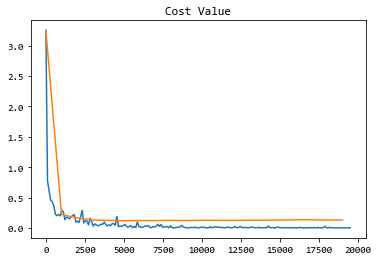

{'update_parameters': 73.22195863723755, 'total': 584.751088142395, 'forwardpropagation_all': 242.0554347038269, 'backpropagate_all': 257.19710540771484, 'tmp': 81.49314045906067}
final test set accuracy:  0.9829


In [18]:
timer = {'forwardpropagation_all':0, 'backpropagate_all':0, 'update_parameters':0, 'tmp':0}

def test_model():
    """test model using random data"""
    m = 10
    X = np.random.randn(784,m)
    Y = one_hot(np.random.randint(low=0, high=10, size=(m,1)))
    #print(X[:,1])
    #print(Y[:,1])
    costs = model(X,Y,learning_rate=0.1, print_every=1, iteration=1,
                 hidden_layers=[10,2])
    plt.plot(costs[1], costs[0])
    plt.show()
    
def main(trial=True):
    """test model using real MNIST dataset"""
    mnist = load_mnist()
    mnist = shuffle_divide_dataset(mnist)
    mnist = standardize(mnist)
    mnist = flat_stack(mnist)
    mnist = one_hot(mnist)
    
    if trial:
        print("Trail")
        costs = model(mnist['X_train'][:,:16], mnist['Y_train'][:,:16], mnist['X_dev'], mnist['Y_dev'],
                  learning_rate=0.1, print_every=100, iteration=1,
                  batch_size=8, regularization=0, keep_prop=0.3,
                  hidden_layers=[5,2])
    else:
        costs = model(mnist['X_train'], mnist['Y_train'], mnist['X_dev'], mnist['Y_dev'],
                  learning_rate=0.1, print_every=1000, iteration=50,
                  batch_size=128, regularization=0, keep_prop=0.8,
                  hidden_layers=[784,1024])
        
    plt.plot(costs[1], costs[0])
    plt.plot(costs[3], costs[2])
    plt.title("Cost Value")
    plt.show()
    
    print(timer)

    forwardpropagation_all(mnist['X_test'], mnist['Y_test'], with_dropout=False)
    Y_hat_test = cache['A'+str(hyper_parameters['L'])]
    Y_predict_test = predict(Y_hat_test)
    accu_test = accuracy(Y_predict_test, mnist['Y_test'])
    print('final test set accuracy: ', accu_test)
    
main(trial=False)

In [19]:
"""
This section is used for testing gradient.
After testing passed, and bugs are eliminated, they should not run any more during trainning.
"""
def test_gradient_general(loss_function, loss_back_function, epsilon):
    m = 30
    nx = 7
    ny = m
    X = np.random.rand(nx,m)
    Y = np.identity(m)
    W = np.random.randn(m, nx)
    b = np.random.randn(m,1)
    
    Approximate = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_p = X.copy()
            X_p[i][j] += epsilon
            Loss_p = loss_function(X_p, Y, W, b)
            X_m = X.copy()
            X_m[i][j] -= epsilon
            Loss_m = loss_function(X_m, Y, W, b)
            Approximate[i][j] = (Loss_p - Loss_m) / 2 / epsilon
    Calculated = loss_back_function(X, Y, W, b)
    difference = np.linalg.norm(Calculated - Approximate) / (np.linalg.norm(Calculated) + np.linalg.norm(Approximate))
    print("Approximate Result = ", Approximate[:2,:2])
    print("Calculated gradient = ", Calculated[:2,:2])
    return difference

""" 
These testing functions might be a little tricky. 
We pass two functions into the general testing function and let the testing function call them to compute difference.
*args can stand for any arguments passed into those functions.
"""
def test_loss_gradient(epsilon=1e-10): #passed
    def loss_function(*args):
        # args: X Y
        return loss(args[0], args[1])
    def loss_back_function(*args):
        return loss_backpropagation(args[0], args[1])
    return test_gradient_general(loss_function, loss_back_function, epsilon)

def test_relu_loss_gradient(epsilon=1e-10): #passed
    def loss_function(*args):
        # args: X Y
        return loss(relu(args[0]), args[1])
    def loss_back_function(*args):
        A = relu(args[0])
        dL_dA = loss_backpropagation(A, args[1])
        dL_dZ = relu_backpropagation(args[0], A, dL_dA)
        return dL_dZ
    return test_gradient_general(loss_function, loss_back_function, epsilon)

def test_softmax_loss_gradient(epsilon=1e-10): # I guess it is passed...
    def loss_function(*args):
        # args: X Y
        return loss(softmax(args[0]), args[1])
    def loss_back_function(*args):
        A = softmax(args[0])
        #print("Y_hat = ", A[:2,:2])
        dL_dZ = softmax_loss_backpropagation(A, args[1])
        return dL_dZ
    return test_gradient_general(loss_function, loss_back_function, epsilon)
        
def test_linear_softmax_loss_gradient(epsilon=1e-10): # 
    np.random.seed(1)
    def loss_function(*args):
        # args: X Y W b
        return loss(softmax( linear(args[0], args[2], args[3]) ), args[1])
    def loss_back_function(*args):
        A = softmax( linear(args[0], args[2], args[3]) )
        #print("Y_hat = ", A[:2,:2])
        dL_dZ = softmax_loss_backpropagation(A, args[1])
        dL_dA_prev,_,_ = linear_backpropagation(args[0], args[2], args[3], dL_dZ)
        return dL_dA_prev
    return test_gradient_general(loss_function, loss_back_function, epsilon)
        
print(test_linear_softmax_loss_gradient(epsilon=1e-10)) #still have relatively large difference on this step.

Approximate Result =  [[-0.00788258  0.03832934]
 [ 0.00287326  0.00975664]]
Calculated gradient =  [[-0.00811102  0.03876382]
 [ 0.00319633  0.00850782]]
0.0550442322486
